# **Training Model based on Big Transfer document from Tensorflow**
### **Link of article:**
**https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/bit.ipynb#scrollTo=8Mmy42HWGV7v**

# **Libraries**

In [ ]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


# **Preparing Dataset**
1. we can directly upload dataset in google colab disk (dhould be zip)
2. we can upload dataset to our google drive and connect to google drive  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **unsip the dataset**

In [ ]:
# !unzip "/content/drive/MyDrive/dataset/animal_photo.zip"

In [ ]:
DATA_PATH = "./animal_photo"
train_dir = os.path.join(DATA_PATH,'train')
val_dir = os.path.join(DATA_PATH,'val')
test_dir = os.path.join(DATA_PATH,'val')

In [ ]:
# testing dataset
print("train, validation and test list: ")
os.listdir(train_dir)
os.listdir(val_dir)
os.listdir(test_dir)

train, validation and test list: 


['lion', 'monkey', 'snake']

# **hyperparameters**
### All images of dataset have the same size (256)



In [ ]:
RESIZE_TO = 224
CROP_TO = 112
IMAGE_SIZE = 112
BATCH_SIZE = 32
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  
NUM_CLASSES = 3  
SCHEDULE_LENGTH = (500) # we will train on lower resolution images and will still attain good results
SCHEDULE_BOUNDARIES = [200, 300, 400,]  # more the dataset size the schedule length increase

## **Preparing our tran and validation data for training**

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                      shuffle=True,
                                                      label_mode = 'categorical',
                                                      batch_size = BATCH_SIZE,
                                                      image_size = (IMAGE_SIZE ,IMAGE_SIZE))
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                      label_mode ='categorical',
                                                      batch_size = BATCH_SIZE,
                                                      image_size = (IMAGE_SIZE ,IMAGE_SIZE))

Found 2295 files belonging to 3 classes.
Found 398 files belonging to 3 classes.


## **Check some images:**

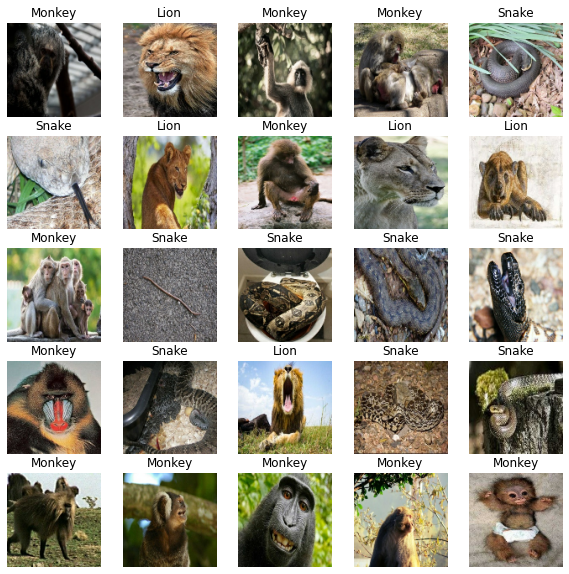

In [ ]:
class_names = ["Lion" ,"Monkey","Snake"]

visualise_data = train_ds.take(1)
plt.figure(figsize=(10, 10))
for image, label in visualise_data:
    for i in range(25):
      ax = plt.subplot(5, 5, i + 1)
      img = image[i]/255.
      plt.imshow(img)
      plt.title(class_names[label[i].numpy().argmax()])
      plt.axis("off")

# **Helper functions:**

In [ ]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (BATCH_SIZE,CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)


@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

# **pipelinning:**

In [ ]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(400)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    val_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# **Loading pretrained Tensorflow-Hub model:**

In [ ]:
BigTr_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(BigTr_model_url)

# **BigTransfer Model:**

In [ ]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, activation = 'softmax', kernel_initializer="zeros")
        self.bit_model = module


    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

# **Define other Hyperparameters:**

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.CategoricalCrossentropy()

# **Compiling model:**

In [ ]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

# **Callbacks:**

In [ ]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, restore_best_weights=True
    )
]

# **training Model:**

In [ ]:
history = model.fit(
    pipeline_train,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks
)

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

In [ ]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

13/13 [==============================] - 3s 184ms/step - loss: 0.0931 - accuracy: 0.9623
Accuracy: 96.23%


In [ ]:
# Save the model
model.save('saved_model',save_format='tf')